### **American Express Default Prediction**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

### Import data

In [2]:
df_train_sample = pd.read_csv('train_data.csv', nrows = 5)

In [3]:
dtypes = {col: 'float16' for col in df_train_sample.select_dtypes(include = 'float64').columns}
columns = [col for col in df_train_sample.columns if col not in ['S_2', 'S_3', 'D_42', 'D_43', 'D_46', 'D_49', 'D_50', 'D_53', 'S_7', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'S_27', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142', 'D_63', 'D_64']]
converters = {col: lambda x: round(float(x), 2) if x != '' else np.nan for col in columns if col != 'customer_ID'}

In [8]:
total_rows = sum(1 for row in open('train_data.csv')) - 1
sample_size = int(total_rows * 0.1)
skip_rows = sorted(np.random.choice(range(1, total_rows + 1), total_rows - sample_size, replace = False))

In [9]:
df_train = pd.read_csv('train_data.csv', usecols = columns, dtype = dtypes, converters = converters, skiprows = skip_rows)

C:\Users\Reazeng\AppData\Local\Temp\ipykernel_2728\1203040581.py:1: ParserWarning: Both a converter and dtype were specified for column P_2 - only the converter will be used.
  df_train = pd.read_csv('train_data.csv', usecols = columns, dtype = dtypes, converters = converters, skiprows = skip_rows)
C:\Users\Reazeng\AppData\Local\Temp\ipykernel_2728\1203040581.py:1: ParserWarning: Both a converter and dtype were specified for column D_39 - only the converter will be used.
  df_train = pd.read_csv('train_data.csv', usecols = columns, dtype = dtypes, converters = converters, skiprows = skip_rows)
C:\Users\Reazeng\AppData\Local\Temp\ipykernel_2728\1203040581.py:1: ParserWarning: Both a converter and dtype were specified for column B_1 - only the converter will be used.
  df_train = pd.read_csv('train_data.csv', usecols = columns, dtype = dtypes, converters = converters, skiprows = skip_rows)
C:\Users\Reazeng\AppData\Local\Temp\ipykernel_2728\1203040581.py:1: ParserWarning: Both a converter

In [10]:
label_train = pd.read_csv('train_labels.csv')

### Data preparation

In [11]:
from sklearn.preprocessing import StandardScaler

#### Remove rows with missing values

In [12]:
missing_ratio = df_train.isnull().mean(axis = 1)
df_train = df_train[missing_ratio == 0]

In [13]:
customer_id = df_train['customer_ID']

#### Normalize the items

In [14]:
scaler = StandardScaler()
df_train = scaler.fit_transform(df_train.drop(columns = ['customer_ID']))
df_train = pd.DataFrame(df_train, columns = columns[1:])

In [15]:
df_train = pd.concat([customer_id, df_train], axis = 1)

In [16]:
df_train = df_train.groupby('customer_ID').mean().reset_index()

#### Reduce dimensionalty by PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
df_train = df_train.fillna(0)

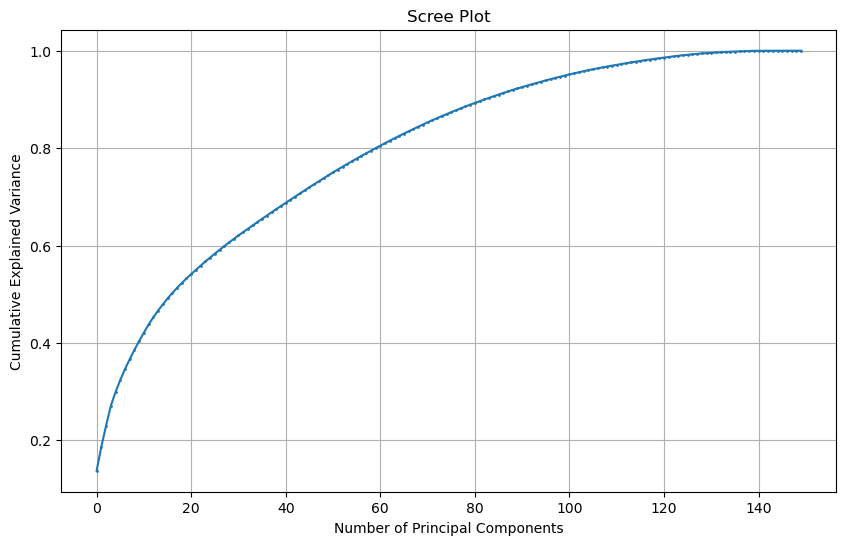

In [19]:
pca = PCA(n_components = 150)
df_train_pca = pca.fit(df_train.drop(columns = ['customer_ID']))

explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker = 'o', linestyle = '-', markersize = 1)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [20]:
pca = PCA(n_components = 120)
df_train_pca = pca.fit(df_train.drop(columns = ['customer_ID']))
df_train_pca = pca.transform(df_train.drop(columns = ['customer_ID']))

df_train_pca = pd.DataFrame(df_train_pca)

#### Merge dataset

In [21]:
customer_id = df_train['customer_ID']

In [22]:
df_train = pd.concat([customer_id, df_train_pca], axis = 1)
df_train = pd.merge(df_train, label_train, on = 'customer_ID')

#### Split and balance data

In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [24]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns = ['customer_ID', 'target']), df_train['target'].astype(int), test_size = 0.3, random_state = 30)

In [25]:
smote = SMOTE(random_state = 30)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### Data Modeling

#### LightGBM

In [46]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, recall_score, f1_score, roc_auc_score

In [23]:
train_data = lgb.Dataset(X_train_smote, label = y_train_smote)
val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

##### Model

In [47]:
params = {
    'num_leaves': [30, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9, 1.0], 
    'bagging_fraction': [0.8, 0.9, 1.0,],
    'importance_type': ['split', 'gain'],
    'n_estimators': [30, 50, 100]
}

lgb_estimator = lgb.LGBMClassifier(objective = 'binary', metric = 'binary_logloss')

scorer = make_scorer(roc_auc_score)

random_search_lgb = RandomizedSearchCV(
    estimator = lgb_estimator,
    param_distributions = params,
    n_iter = 10,
    scoring = scorer,
    verbose = 1,
    random_state = 30,
    n_jobs = -1
    )

random_search_lgb.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 129569, number of negative: 129569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 259138, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [W

In [58]:
best_lgb = random_search_lgb.best_estimator_
y_pred_train_lgb = best_lgb.predict(X_train_smote)
y_pred_lgb = best_lgb.predict(X_val)
y_pred_lgb = [1 if x > 0.5 else 0 for x in y_pred_lgb]

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


##### Classification report

Training set

In [59]:
cr_train_lgb = classification_report(y_train_smote, y_pred_train_lgb, output_dict = True)
cr_train_lgb = pd.DataFrame(cr_train_lgb).transpose()

In [60]:
cr_train_lgb

,precision,recall,f1-score,support
0,0.648685,0.836543,0.730733,129569.000000
1,0.769909,0.546944,0.639551,129569.000000
accuracy,0.691743,0.691743,0.691743,0.691743
macro avg,0.709297,0.691743,0.685142,259138.000000
weighted avg,0.709297,0.691743,0.685142,259138.000000


In [61]:
cr_lgb = classification_report(y_val, y_pred_lgb, output_dict = True)
cr_lgb = pd.DataFrame(cr_lgb).transpose()

In [62]:
cr_lgb

,precision,recall,f1-score,support
0,0.736720,0.776847,0.756252,55648.000000
1,0.262282,0.222261,0.240619,19864.000000
accuracy,0.630959,0.630959,0.630959,0.630959
macro avg,0.499501,0.499554,0.498435,75512.000000
weighted avg,0.611916,0.630959,0.620611,75512.000000


##### Confusion matrix

In [63]:
cm_lgb = confusion_matrix(y_val, y_pred_lgb)
cm_lgb = pd.DataFrame(cm_lgb, index = ['Actual Negative', 'Actual Positive'], columns = ['Predicted Negative', 'Predicted Positive'])

In [64]:
cm_lgb

,Predicted Negative,Predicted Positive
Actual Negative,43230,12418
Actual Positive,15449,4415


#### Randon Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

##### Model

In [27]:
param_dict = {
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 5)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state = 30)

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_dict,
    n_iter = 5,
    verbose = 2,
    random_state = 30,
    n_jobs = -1,
    scoring = 'recall',
    cv = None
)

rf_random.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\Reazeng\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Reazeng\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Reazeng\anaconda3\envs\tf\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Reazeng\anaconda3\envs\tf\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Us

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=30), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 62, 75, 87, 100]},
                   random_state=30, scoring='recall', verbose=2)

In [28]:
best_rf = rf_random.best_estimator_
y_pred_train_rf = best_rf.predict(X_train_smote)
y_pred_rf = best_rf.predict(X_val)

##### Classification report

Training set

In [31]:
cr_train_rf = classification_report(y_train_smote, y_pred_train_rf, output_dict = True)
cr_train_rf = pd.DataFrame(cr_train_rf).transpose()

In [32]:
cr_train_rf

,precision,recall,f1-score,support
0,0.800941,1.000000,0.889469,129569.000000
1,1.000000,0.751468,0.858101,129569.000000
accuracy,0.875734,0.875734,0.875734,0.875734
macro avg,0.900470,0.875734,0.873785,259138.000000
weighted avg,0.900470,0.875734,0.873785,259138.000000


Validation set

In [33]:
cr_val_rf = classification_report(y_val, y_pred_rf, output_dict = True)
cr_val_rf = pd.DataFrame(cr_val_rf).transpose()

In [34]:
cr_val_rf

,precision,recall,f1-score,support
0,0.737106,0.897858,0.809579,55648.000000
1,0.264493,0.102900,0.148159,19864.000000
accuracy,0.688738,0.688738,0.688738,0.688738
macro avg,0.500799,0.500379,0.478869,75512.000000
weighted avg,0.612782,0.688738,0.635588,75512.000000


##### Confusion matrix

In [184]:
cm_rf = confusion_matrix(y_val, y_pred_rf)
cm_rf = pd.DataFrame(cm_rf, index = ['Actual Negative', 'Actual Positive'], columns = ['Predicted Negative', 'Predicted Positive'])

In [ ]:
cm_rf